In [1]:
import numpy as np
from cellpose import models, core, io, plot
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt
from natsort import natsorted

io.logger_setup() # run this to get printing of progress

#Check if colab notebook instance has GPU access
if core.use_gpu()==False:
  raise ImportError("No GPU access, change your runtime")

model = models.CellposeModel()




Welcome to CellposeSAM, cellpose v4.0.1! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 


2025-05-07 15:23:34,177 [INFO] WRITING LOG OUTPUT TO /Users/demir/.cellpose/run.log
2025-05-07 15:23:34,178 [INFO] 
cellpose version: 	4.0.2.dev5+g636f0ee 
platform:       	darwin 
python version: 	3.10.17 
torch version:  	2.6.0
2025-05-07 15:23:34,220 [INFO] ** TORCH MPS version installed and working. **
2025-05-07 15:23:34,220 [INFO] >>>> using CPU
2025-05-07 15:23:34,222 [INFO] >>>> using CPU
2025-05-07 15:23:35,238 [INFO] >>>> loading model /Users/demir/.cellpose/models/cpsam


In [2]:
file_name = f"/Users/demir/Documents/Hva_AI/afstudeerproject/codes_yunus/input/tif_deneme_1.tif"
img = io.imread(file_name) # (9, 4, 1024, 1024)
print(f'img : {img.shape}')

# CELL BODY
img_cellbody = img[:, 3, :, :]
img_cellbody = img_cellbody[6, :, :]
print(f'cell body : {img_cellbody.shape}')

# NUCLEI
img_nuclei = img[:, 0, :, :]
img_nuclei = img_nuclei[6, :, :]
print(f'Nuclei : {img_nuclei.shape}')

# NUCLEI
img_aggregate = img[:, 2, :, :]
img_aggregate = img_aggregate[6, :, :]
print(f'Aggregate : {img_aggregate.shape}')

2025-05-07 15:23:40,853 [INFO] reading tiff with 36 planes


100%|██████████| 36/36 [00:00<00:00, 576.24it/s]

img : (9, 4, 1024, 1024)
cell body : (1024, 1024)
Nuclei : (1024, 1024)
Aggregate : (1024, 1024)


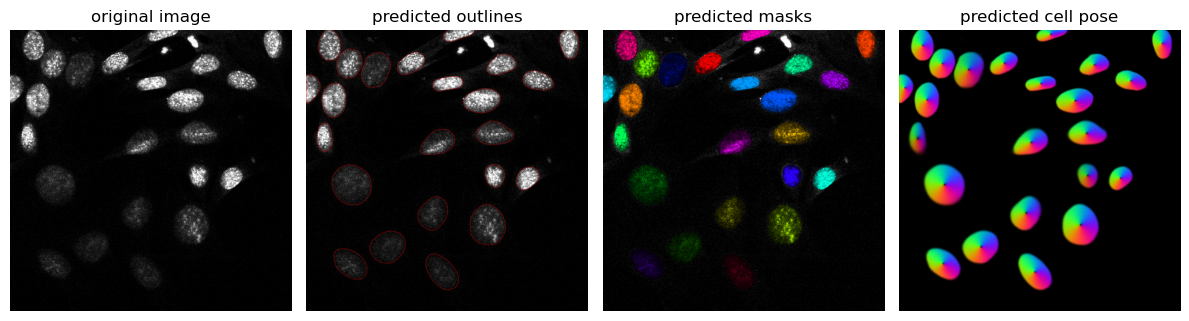

In [11]:
masks_nuclei, flows_nuclei, styles_nuclei = model.eval(
                                                        img_nuclei,
                                                        batch_size=8, 
                                                        flow_threshold=0.4, 
                                                        cellprob_threshold=0.0, 
                                                        diameter=50,
                                                        normalize={"tile_norm_blocksize": 0}
                                                    )

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img_nuclei, masks_nuclei, flows_nuclei[0])
plt.tight_layout()
plt.show()
# 3 min runtime batch 32, diameter = 30
# 1:30 min runtime - batch 8 diameter = 30
# 1:30 min runtime - batch 8 diameter = 50
# 22 sec runtime - batch 8 diameter = 50
# 20 sec runtime - batch 4 diameter = 50
# 34 sec runtime - batch 4 diameter = 40

In [10]:
# Kaç hücre bulundu?
num_cells = masks_nuclei.max()
print(f"Toplam hücre sayısı: {num_cells}")


Toplam hücre sayısı: 23


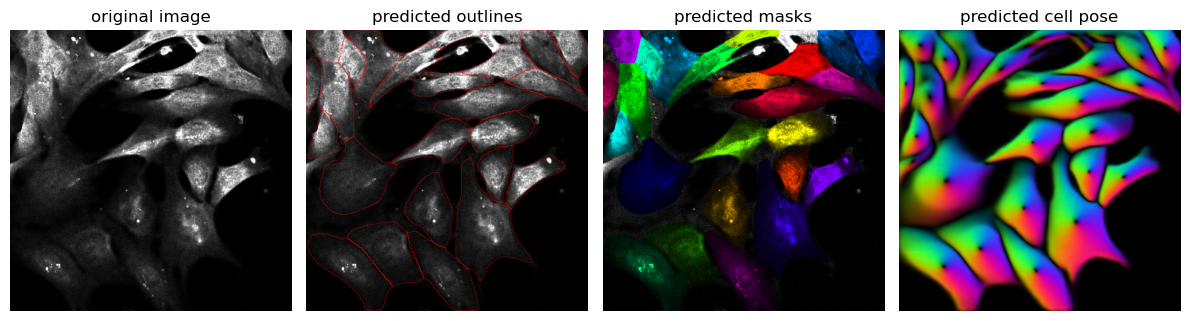

In [26]:
masks_cellbody, flows_cellbody, styles_cellbody = model.eval(
                                                        img_cellbody,
                                                        batch_size=8, 
                                                        flow_threshold=0.4, 
                                                        cellprob_threshold=0.0, 
                                                        diameter=100,
                                                        normalize={"tile_norm_blocksize": 0}
                                                    )

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img_cellbody, masks_cellbody, flows_cellbody[0])
plt.tight_layout()
plt.show()

# 16 sec - batch 8

In [27]:
# Kaç hücre bulundu?
num_cells = masks_cellbody.max()
print(f"Toplam hücre sayısı: {num_cells}")


Toplam hücre sayısı: 24


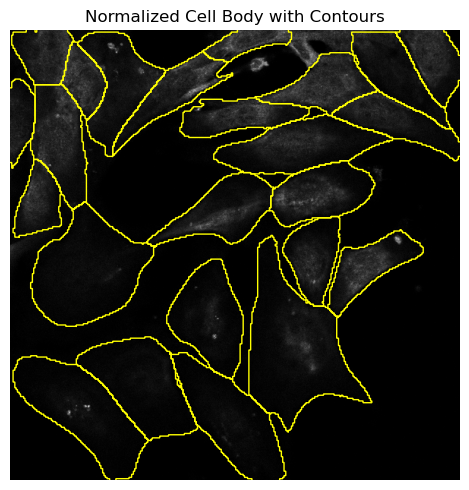

In [84]:
from skimage import measure
import matplotlib.pyplot as plt
import numpy as np

# Görüntüyü normalize et (0–1 aralığına getir)
def normalize(img):
    img = img.astype(np.float32)
    return (img - img.min()) / (img.max() - img.min() + 1e-8)

# Normalize edilmiş cellbody görüntüsü
img_norm = normalize(img_cellbody)

# Çizim
fig, ax = plt.subplots(figsize=(12, 5))
ax.imshow(img_norm, cmap='gray')

# Sınırları çiz (örnek: sarı)
for region in measure.regionprops(masks_cellbody):
    for coords in measure.find_contours(masks_cellbody == region.label, 0.5):
        ax.plot(coords[:, 1], coords[:, 0], color='yellow', linewidth=1)

ax.set_title("Normalized Cell Body with Contours")
ax.axis('off')
plt.tight_layout()
plt.show()


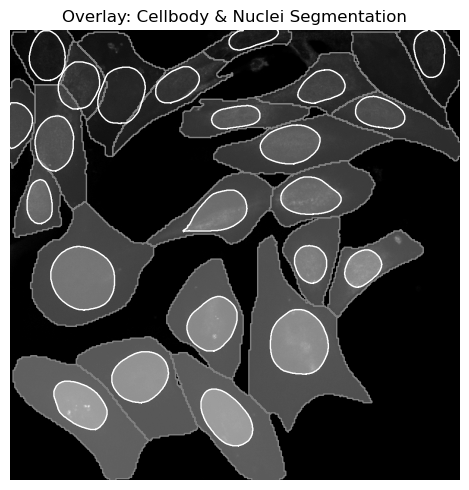

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure

# Görüntüyü normalize et
def normalize(img):
    return (img - img.min()) / (img.max() - img.min())

# Maskelerin üzerine segmentasyon çizin
def plot_overlay(original_img, cellbody_mask, nuclei_mask, alpha=0.5):
    fig, ax = plt.subplots(figsize=(12, 5))
    
    # Orijinal görüntüyü gri tonlarında göster
    ax.imshow(original_img, cmap='gray', alpha=1.0)

    # Hücre gövdesi segmentasyonunu (sadece kenarları) gri tonla çiz
    for region in measure.regionprops(cellbody_mask):
        for coords in measure.find_contours(cellbody_mask == region.label, 0.5):
            ax.plot(coords[:, 1], coords[:, 0], color='gray', linewidth=1)

    # Çekirdek segmentasyonunu (sadece kenarları) beyaz tonla çiz
    for region in measure.regionprops(nuclei_mask):
        for coords in measure.find_contours(nuclei_mask == region.label, 0.5):
            ax.plot(coords[:, 1], coords[:, 0], color='white', linewidth=1)

    # Hücre gövdesi segmentasyonunu şeffaf gri yaparak overlay et
    ax.imshow(cellbody_mask, cmap='gray', alpha=alpha)  # Gri renk, şeffaflık ile

    # Çekirdek segmentasyonunu şeffaf beyaz yaparak overlay et
    ax.imshow(nuclei_mask, cmap='gray', alpha=alpha/2)  # Beyaz renk, daha düşük şeffaflık

    ax.set_title("Overlay: Cellbody & Nuclei Segmentation")
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Görüntüyü normalize et
img_norm = normalize(img_cellbody)

# Maskeleri overlay et (gri ve beyaz segmentasyon çizgileri, %50 şeffaflık)
plot_overlay(img_norm, masks_cellbody, masks_nuclei, alpha=0.5)


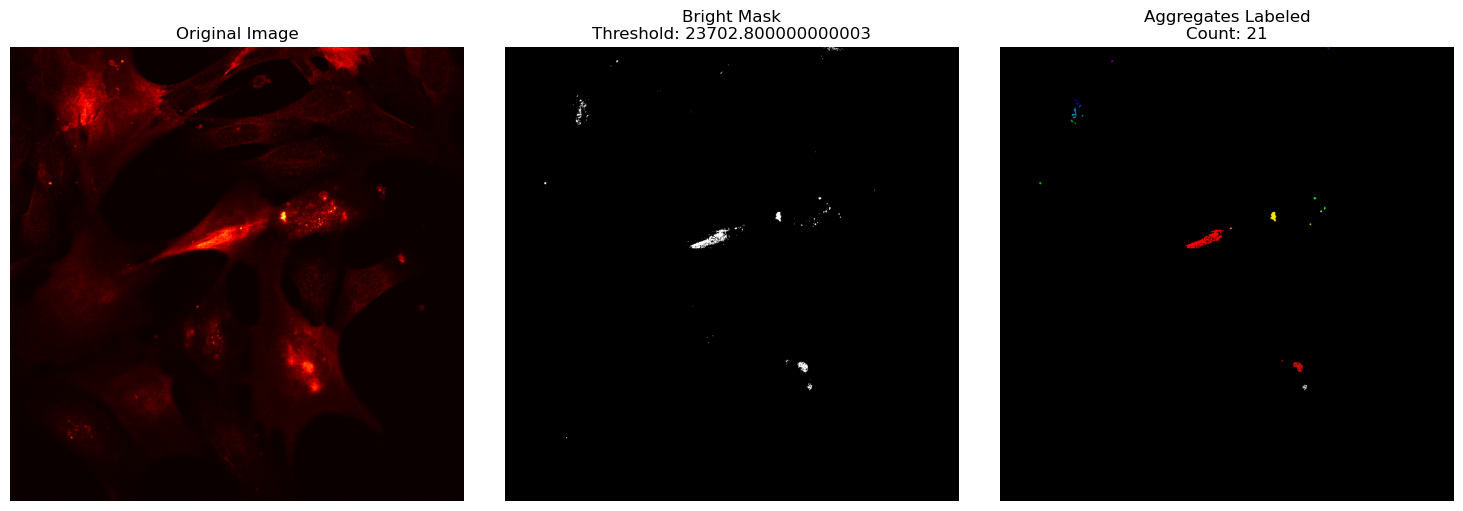

Total aggregations: 21


In [116]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure, morphology

# Eşik belirle: Parlak olan pikselleri yakalamak için
# threshold = int(img_aggregate.mean() + 6 * img_aggregate.std())


# from skimage.filters import threshold_otsu
# threshold = threshold_otsu(img_aggregate)

# from skimage.filters import threshold_li
# threshold = threshold_li(img_aggregate)

# from skimage.filters import threshold_triangle
# threshold = threshold_triangle(img_aggregate)

threshold = 0.4 * np.max(img_aggregate)



# Eşikle parlak noktaları seç
bright_spots = img_aggregate > threshold

# Küçük gürültüleri temizle
clean_mask = morphology.remove_small_objects(bright_spots, min_size=10)

# Bağlantılı bileşenleri etiketle
labeled_mask = measure.label(clean_mask)
num_aggregations = labeled_mask.max()

# Görselleştir
plt.figure(figsize=(15, 5))

# 1. Orijinal görüntü
plt.subplot(1, 3, 1)
plt.imshow(img_aggregate, cmap='hot')
plt.axis('off')
plt.title('Original Image')

# 2. Binary maske (eşiklenmiş parlak bölgeler)
plt.subplot(1, 3, 2)
plt.imshow(bright_spots, cmap='gray')
plt.axis('off')
plt.title(f'Bright Mask\nThreshold: {threshold}')

# 3. Etiketlenmiş agregatlar
plt.subplot(1, 3, 3)
plt.imshow(labeled_mask, cmap='nipy_spectral')
plt.axis('off')
plt.title(f'Aggregates Labeled\nCount: {num_aggregations}')

plt.tight_layout()
plt.show()

print(f"Total aggregations: {num_aggregations}")


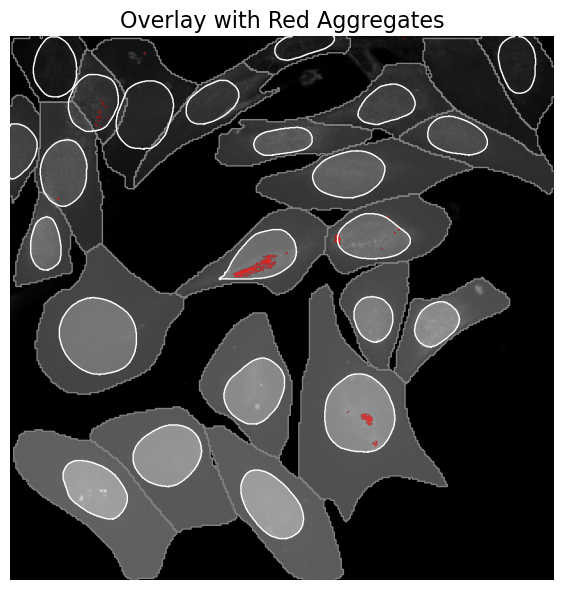

In [117]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure

def normalize(img):
    return (img - img.min()) / (img.max() - img.min())

def plot_overlay_with_red_aggregates(original_img, cellbody_mask, nuclei_mask, aggregate_mask, alpha=0.5):
    fig, ax = plt.subplots(figsize=(12, 6))

    # Ana görüntü (gri)
    ax.imshow(original_img, cmap='gray', alpha=1.0)

    # Hücre sınırları (gri çizgi)
    for region in measure.regionprops(cellbody_mask):
        for coords in measure.find_contours(cellbody_mask == region.label, 0.5):
            ax.plot(coords[:, 1], coords[:, 0], color='gray', linewidth=1)

    # Çekirdek sınırları (beyaz çizgi)
    for region in measure.regionprops(nuclei_mask):
        for coords in measure.find_contours(nuclei_mask == region.label, 0.5):
            ax.plot(coords[:, 1], coords[:, 0], color='white', linewidth=1)

    # Maskeler (gri ve beyaz)
    ax.imshow(cellbody_mask, cmap='gray', alpha=alpha)
    ax.imshow(nuclei_mask, cmap='gray', alpha=alpha/2)

    # Kırmızı agregat maske (0 olan yerleri gizle)
    red_overlay = np.zeros((*aggregate_mask.shape, 4))  # RGBA
    red_overlay[aggregate_mask > 0] = [1, 0, 0, 0.7]  # kırmızı, %70 opak

    ax.imshow(red_overlay)

    ax.set_title("Overlay with Red Aggregates", fontsize=16)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# normalize edilmiş görüntü
img_norm = normalize(img_cellbody)

# aggregate_mask: clean_mask veya bright_spots olabilir
plot_overlay_with_red_aggregates(img_norm, masks_cellbody, masks_nuclei, clean_mask)
